In [ ]:
# This notebook project is a python-based pipeline for bulk RNA-seq analysis, 
# which includes the basic steps such as quality control, count filtering and normalisation, data visualisation, and functional enrichment analysis. 
# Two input files are required, a gene-sample count matrix with gene names 
# and sample names as row names and column names respectively, and a list of differentiated expressed genes for gene set enrichment analysis (GSEA). 
# In the end of this notebook project, k-means clustering of transcriptomic profiling data was performed using rnalysis to obtain the possible correlated gene-gene interaction network. 

# In this example, the RNAseq data of human blood cells from leukaemia patients is used. 
# Based on their response to a chemotherapy, patients are classified as responders (R) and non-responders (NR). 
# ‘data_count’ is the beforementioned raw count data. 
# In addition, the differentiated-expressed genes between two groups are collected in ‘data_de’. 

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import random
from adjustText import adjust_text

data_count = pd.read_csv("/Users/zijianfang/Documents/RNAlysis/Counts_RvsNR_Baseline_raw.csv").drop_duplicates(subset=['Geneid'],keep='first')
data_de = pd.read_csv("/Users/zijianfang/Documents/RNAlysis/Gene_DE.csv").dropna()

In [93]:
# data input and filter the gene/transcript with low count read
data_filtered = data_count[data_count.sum(axis = 1) > 100]
data_modified = data_filtered.set_index('Geneid')

<AxesSubplot:>

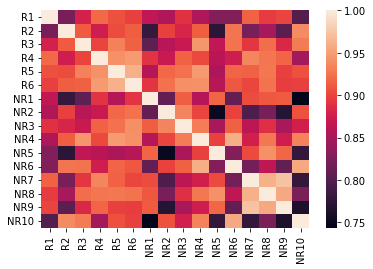

In [9]:
# correlation heatmap is drawn to check the relationship of samples 
plt.figure()
corr = data_modified.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

<AxesSubplot:>

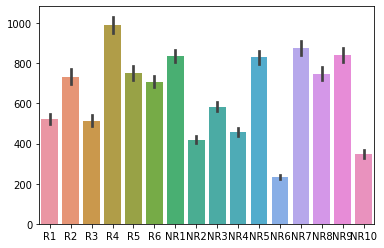

In [10]:
# check the library size 
plt.figure()
sns.barplot(data_modified)

<AxesSubplot:>

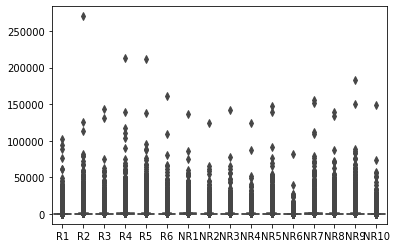

In [11]:
# check the count distribution inside each sample
plt.figure()
sns.boxplot(data_modified)

In [52]:
# PCA is performed to select the potentially important features that distinguish the responders from non-responders
data_normalised =(data_modified - data_modified.mean()) / data_modified.std()
pca = PCA(n_components=data_modified.shape[1])
pca.fit(data_normalised)
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(data_normalised.columns))],
index=data_normalised.columns)
print(loadings)

           PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
R1    0.246320 -0.145874 -0.331430  0.383682  0.605227  0.355527 -0.023702   
R2    0.245502  0.313172  0.085881  0.140936 -0.527988  0.552048 -0.256519   
R3    0.253003  0.104333  0.362963  0.250985  0.240405  0.032838 -0.099209   
R4    0.254519 -0.090793 -0.180632  0.220007 -0.231315 -0.070323  0.673161   
R5    0.257890  0.066701 -0.060996  0.179866 -0.030385 -0.489368 -0.004084   
R6    0.257999  0.053788 -0.164694  0.020784 -0.294399 -0.268229 -0.004382   
NR1   0.242920 -0.314646 -0.256994 -0.464697 -0.148680  0.267666 -0.024533   
NR2   0.243813  0.310798 -0.433295 -0.072956  0.098762 -0.235279 -0.460834   
NR3   0.253041  0.075172 -0.355057 -0.332018  0.089795  0.069878  0.120898   
NR4   0.256927  0.129525  0.217868 -0.201521  0.096113 -0.249461  0.034185   
NR5   0.242251 -0.307708  0.351576 -0.422844  0.189426  0.011794 -0.094834   
NR6   0.249539  0.291554  0.183433 -0.185106  0.155511  0.149677

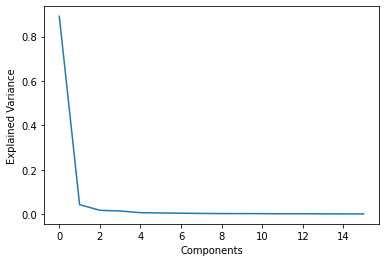

In [84]:
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

In [131]:
pca_df = pd.DataFrame(
    data=loadings, 
    columns=['PC0', 'PC1'])
list = ['responder'] * 6 + ['nonresponder'] * 10
pca_df['target'] = list

PC0       PC1        target
R1    0.246320 -0.145874     responder
R2    0.245502  0.313172     responder
R3    0.253003  0.104333     responder
R4    0.254519 -0.090793     responder
R5    0.257890  0.066701     responder
R6    0.257999  0.053788     responder
NR1   0.242920 -0.314646  nonresponder
NR2   0.243813  0.310798  nonresponder
NR3   0.253041  0.075172  nonresponder
NR4   0.256927  0.129525  nonresponder
NR5   0.242251 -0.307708  nonresponder
NR6   0.249539  0.291554  nonresponder
NR7   0.249835 -0.317939  nonresponder
NR8   0.254814 -0.227856  nonresponder
NR9   0.247517 -0.359925  nonresponder
NR10  0.243168  0.417027  nonresponder

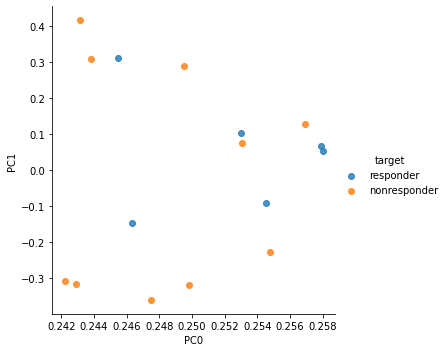

In [136]:
# PCA visualisation, not good separation from first two PCs 
sns.lmplot(
    x='PC0', 
    y='PC1', 
    data=pca_df, 
    hue = 'target',
    fit_reg =False, 
    legend=True
    )

In [85]:
# Now we start to look at the differentiated-expressed gene list and draw the volcano plot
data_de['nlog10'] = -np.log10(data_de.FDR)
def map_color(a):
    logFC, Symbol, nlog10 = a 
    
    if abs(logFC) < 1 or nlog10 < 2:
        return 'nobody_cares'
    return 'i_care'
data_de['color'] = data_de[['logFC', 'Symbol', 'nlog10']].apply(map_color, axis = 1)

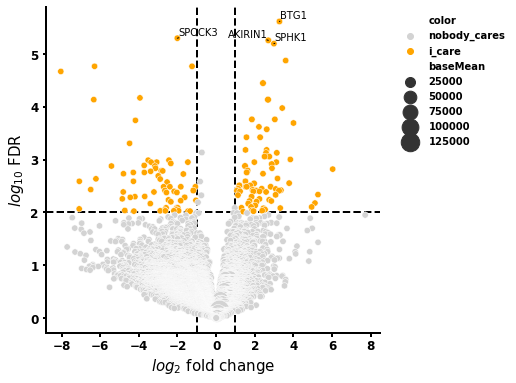

In [89]:
#volcano plot
plt.figure(figsize = (6,6))
ax = sns.scatterplot(data = data_de, x = 'logFC', y = 'nlog10',
                    hue = 'color', hue_order =['nobody_cares','i_care'],
                    palette = ['lightgrey','orange'],
                    size = 'baseMean',
                    sizes = (40,400))

ax.axhline(2, zorder = 0, c = 'k', lw = 2, ls = '--')
ax.axvline(1, zorder = 0, c = 'k', lw = 2, ls = '--')
ax.axvline(-1, zorder = 0, c = 'k', lw = 2, ls = '--')

texts = []
for i in range(len(data_de)):
    if data_de.iloc[i].nlog10 > 5 and abs(data_de.iloc[i].logFC) > 2:
        texts.append(plt.text(x = data_de.iloc[i].logFC, y = data_de.iloc[i].nlog10, s =data_de.iloc[i].Symbol))

adjust_text(texts, arrowprops = dict(arrowstyle ='-', color = 'k'))

plt.legend(loc = 1, bbox_to_anchor = (1.4, 1), frameon = False, prop = {'weight':'bold'})

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(width = 2)

plt.xticks(size = 12, weight = 'bold')
plt.yticks(size = 12, weight = 'bold')

plt.xlabel("$log_{2}$ fold change", size = 15)
plt.ylabel("$log_{10}$ FDR", size = 15)

plt.show()

In [91]:
import gseapy as gp
from gseapy.plot import gseaplot

In [102]:
#GSEA plot 
data_gsea = data_de.rename(columns = {'Symbol' : 'Gene'})
data_gsea = data_gsea[data_gsea.FDR < 0.05].dropna()
data_gsea['Rank'] = -np.log10(data_gsea.FDR)*data_gsea.logFC
data_gsea = data_gsea.sort_values('Rank', ascending = False)
ranking = data_gsea[['Gene', 'Rank']]

In [107]:
#GSEA plot was generated using GO_Biological_Process_2021
pre_res = gp.prerank(rnk= ranking,
                     gene_sets = 'GO_Biological_Process_2021',
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, 
                     outdir=None, 
                     seed=6,
                     verbose=True
                    )

2022-10-21 10:33:24,639 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2022-10-21 10:33:24,651 Parsing data files for GSEA.............................
2022-10-21 10:33:25,341 Downloading and generating Enrichr library gene sets......
2022-10-21 10:33:43,506 5767 gene_sets have been filtered out when max_size=1000 and min_size=5
2022-10-21 10:33:43,507 0269 gene_sets used for further statistical testing.....
2022-10-21 10:33:43,508 Start to run GSEA...Might take a while..................
2022-10-21 10:33:44,002 Congratulations. GSEApy runs successfully................



In [111]:
out = []

for term in list(pre_res.results):
    out.append([term,
               pre_res.results[term]['fdr'],
               pre_res.results[term]['es'],
               pre_res.results[term]['nes']])
    
out_df = pd.DataFrame(out, columns = ['Term', 'fdr', 'es', 'nes']).sort_values('fdr').reset_index(drop = True)

Term       fdr        es  \
0      cellular protein metabolic process (GO:0044267)  0.054617  0.742908   
1    positive regulation of vasculature development...  0.235922  0.800193   
2    regulation of nucleic acid-templated transcrip...  0.237154  0.490971   
3    regulation of cytokine-mediated signaling path...  0.248652  0.707737   
4    positive regulation of cell differentiation (G...  0.255838  0.620979   
..                                                 ...       ...       ...   
264          peptidyl-serine modification (GO:0018209)  1.000000 -0.663842   
265       peptidyl-serine phosphorylation (GO:0018105)  1.000000 -0.623610   
266  positive regulation of phosphatidylinositol 3-...  1.000000 -0.798108   
267          cellular response to hypoxia (GO:0071456)  1.000000 -0.628389   
268  positive regulation of cell cycle process (GO:...  1.000000 -0.541187   

          nes  
0    2.068366  
1    1.767931  
2    1.784319  
3    1.821159  
4    1.883138  
..        ...  
264 -1.636750  
265 -1.436756  
266 -1.672570  
267 -1.297521  
268 -1.337040  

[269 rows x 4 columns]

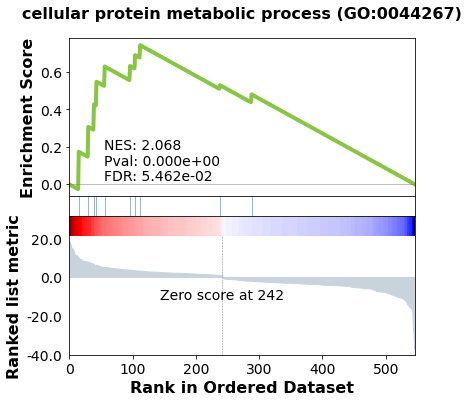

In [117]:
#The top result of GSEA 
term_to_graph = out_df.iloc[0].Term
gseaplot(pre_res.ranking, term = term_to_graph, **pre_res.results[term_to_graph])

In [76]:
data_modified.to_csv("/Users/zijianfang/Documents/RNAlysis/Counts_RvsNR_Baseline_removed.csv", index = True)

In [54]:
from rnalysis import filtering

In [78]:
#The raw count data is normalised for kmeans clustering
counts_input = filtering.CountFilter("/Users/zijianfang/Documents/RNAlysis/Counts_RvsNR_Baseline_removed.csv")
counts_input.normalize_rle()

Normalized the values of 29721 features. Normalized inplace.


Estimating the optimal number of clusters using the Silhouette method in range 2:20...
Using the Silhouette method, 2 was chosen as the best number of clusters (k).


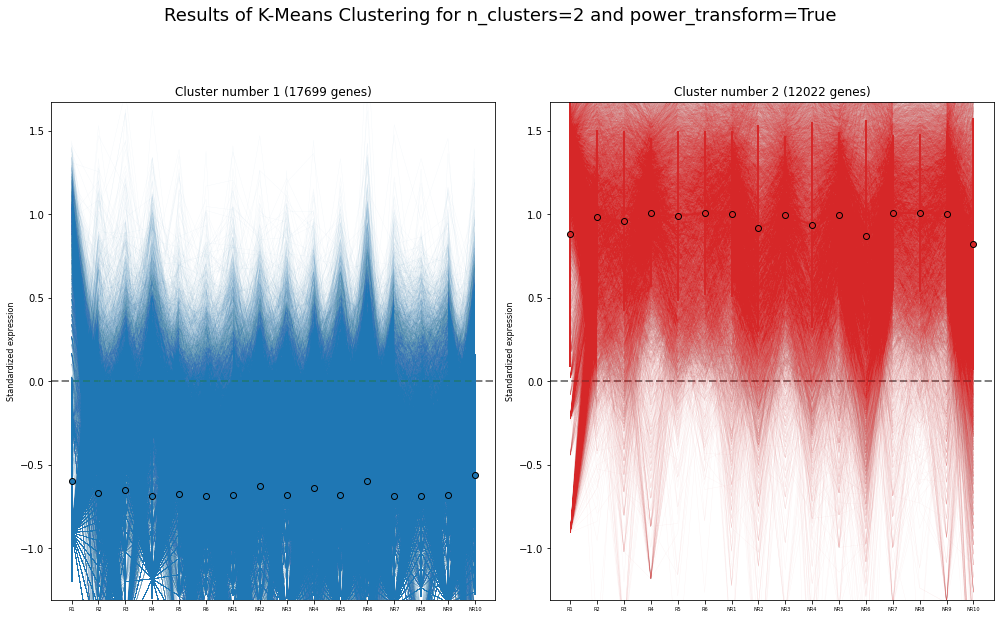

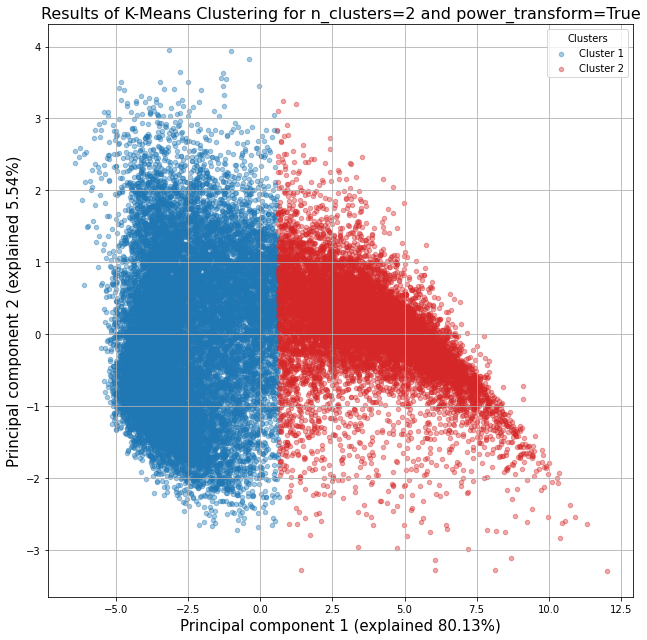

Filtered 12022 features, leaving 17699 of the original 29721 features. Filtering result saved to new object.
Filtered 17699 features, leaving 12022 of the original 29721 features. Filtering result saved to new object.
Estimating the optimal number of clusters using the Gap Statistic method in range 2:20...


Testing 'n_clusters' values:   0%|          | 0/20 [00:00<?, ?values/s]

Using the Gap Statistic method, 2 was chosen as the best number of clusters (K).
Other potentially good values of K that were found: [3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]. 


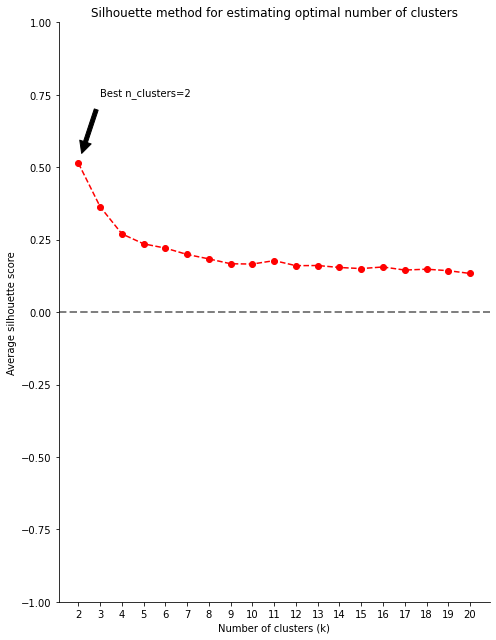

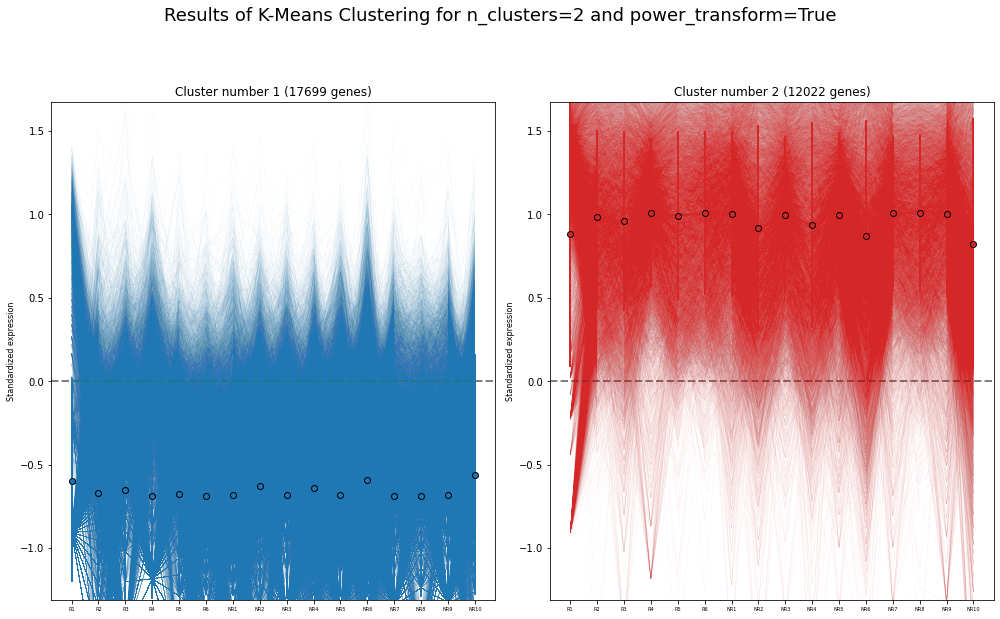

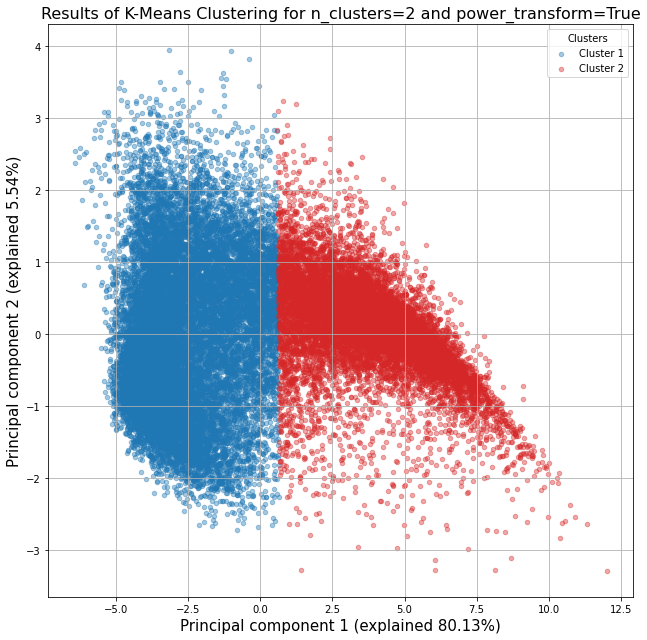

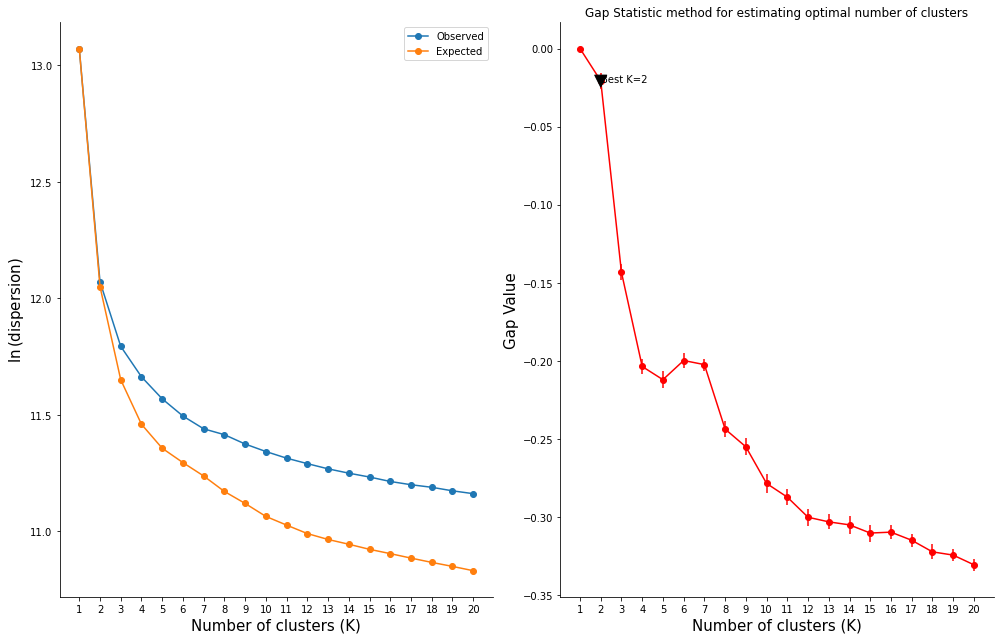

Filtered 12022 features, leaving 17699 of the original 29721 features. Filtering result saved to new object.
Filtered 17699 features, leaving 12022 of the original 29721 features. Filtering result saved to new object.


In [79]:
# estimate the possible cluster number and generate the clustering, however, it is not good in this dataset
silhouette_clusters = counts_input.split_kmeans(n_clusters='silhouette')
gap_stat_clusters = counts_input.split_kmeans(n_clusters='gap')

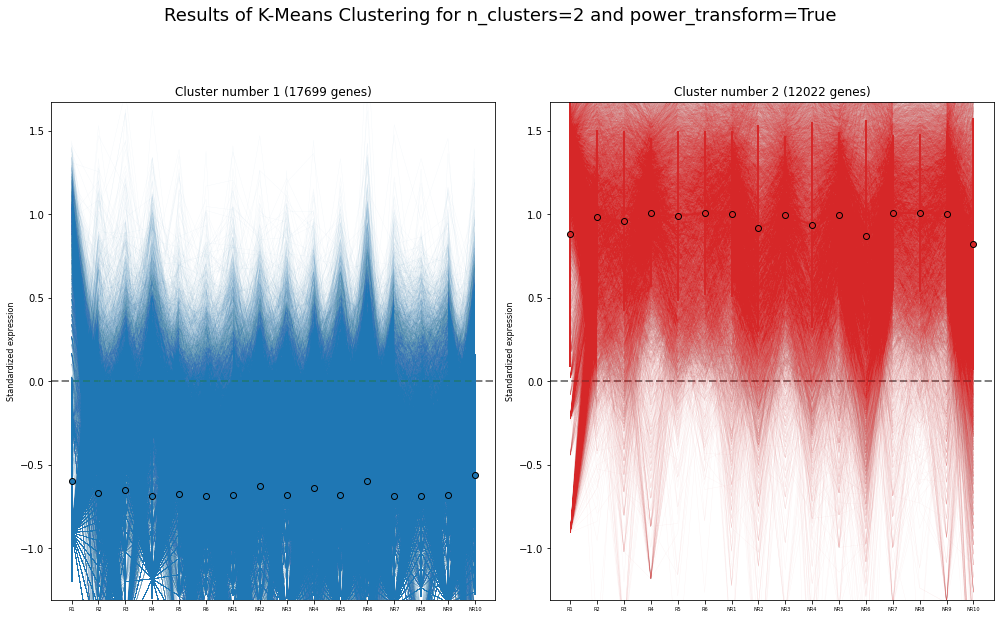

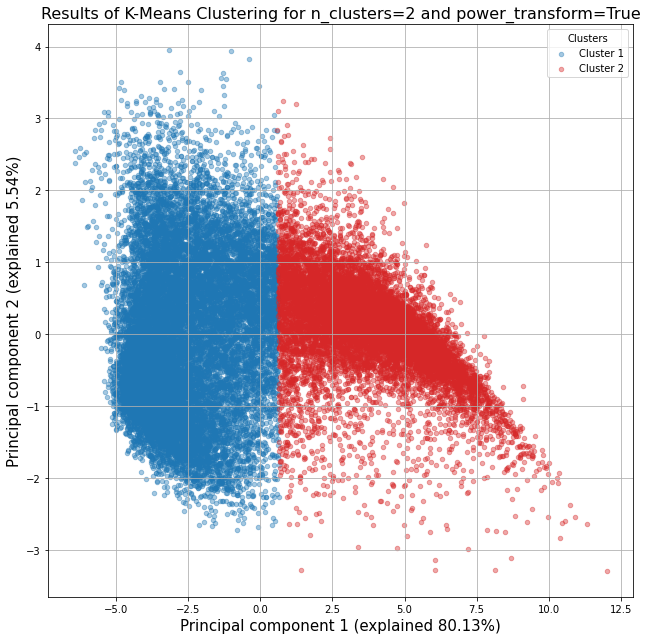

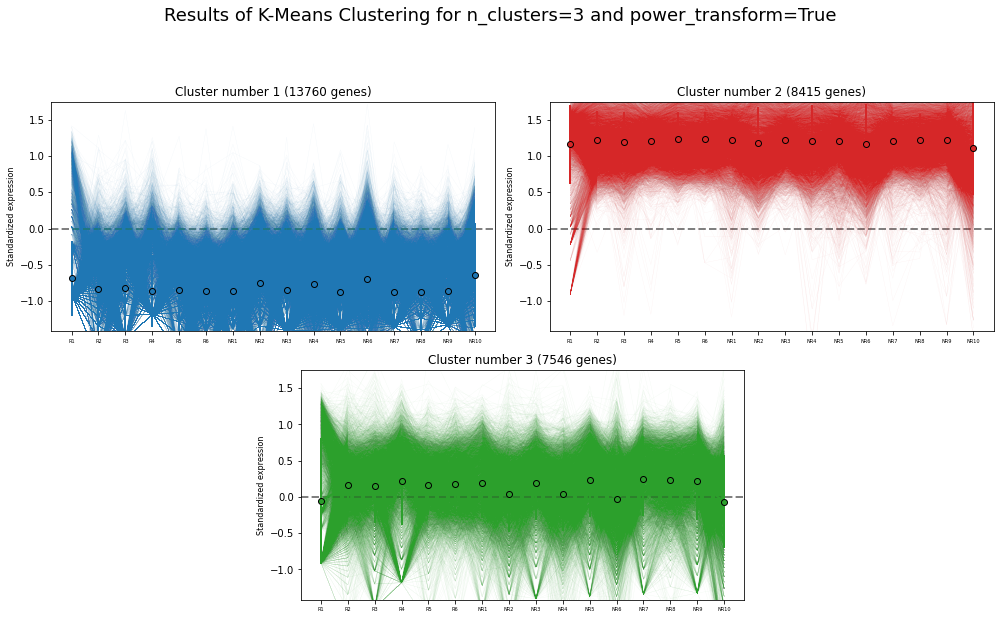

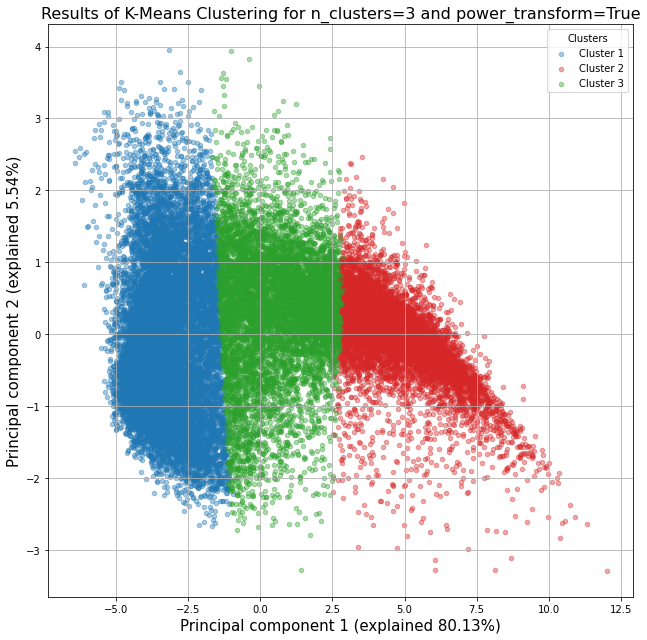

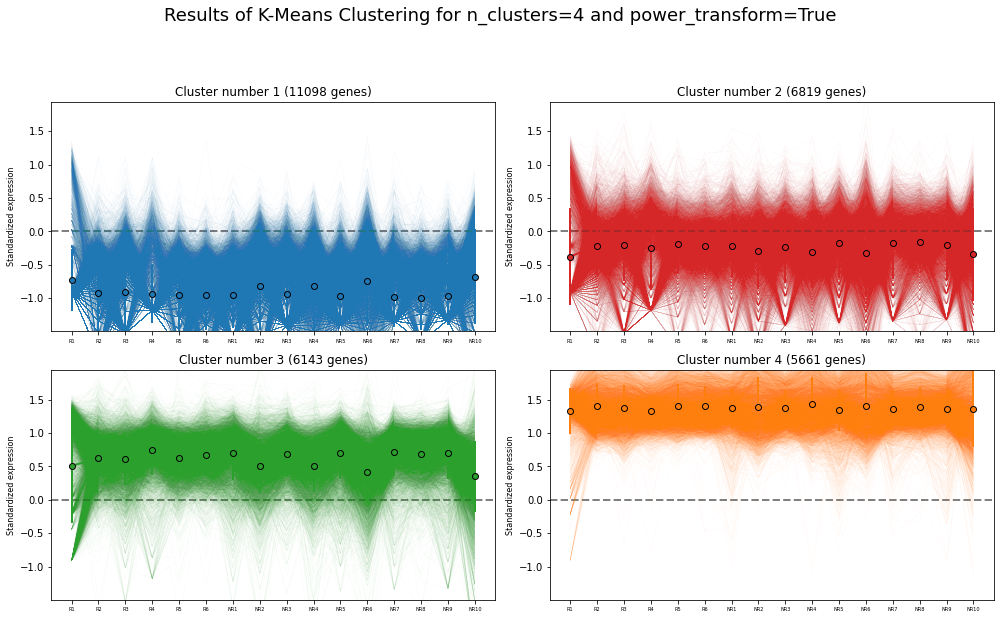

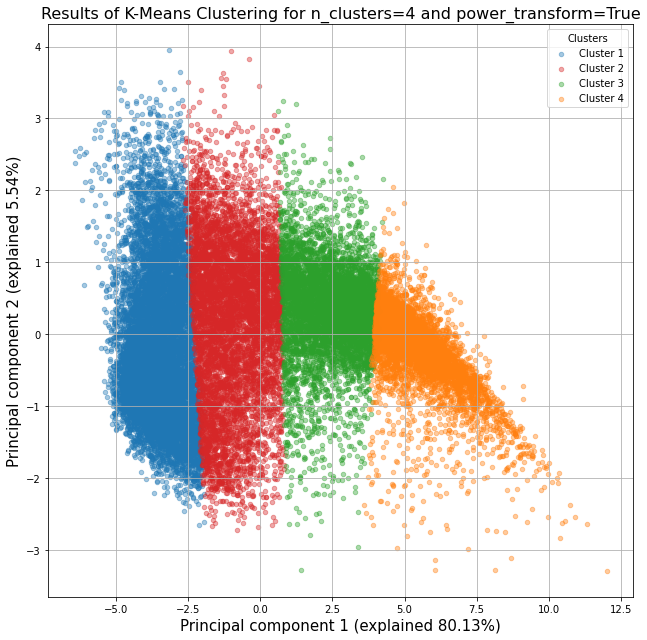

Filtered 12022 features, leaving 17699 of the original 29721 features. Filtering result saved to new object.
Filtered 17699 features, leaving 12022 of the original 29721 features. Filtering result saved to new object.
Filtered 15961 features, leaving 13760 of the original 29721 features. Filtering result saved to new object.
Filtered 21306 features, leaving 8415 of the original 29721 features. Filtering result saved to new object.
Filtered 22175 features, leaving 7546 of the original 29721 features. Filtering result saved to new object.
Filtered 18623 features, leaving 11098 of the original 29721 features. Filtering result saved to new object.
Filtered 22902 features, leaving 6819 of the original 29721 features. Filtering result saved to new object.
Filtered 23578 features, leaving 6143 of the original 29721 features. Filtering result saved to new object.
Filtered 24060 features, leaving 5661 of the original 29721 features. Filtering result saved to new object.


In [81]:
two_clusters, three_clusters, four_clusters = counts_input.split_kmeans(n_clusters=[2, 3, 4])